--------------------------------------------------------------------------------

# **Niloufar Abbasi | 401209996**
# **Deep Learning | Homework 3 | Part 2**

--------------------------------------------------------------------------------

**این تمرین شامل دو بخش می باشد. هدف تمرین شناخت کانوولوشن دگردیس پذیر یا دفرمبل است**





--------------------------------------------------------------------------------
# **سوالات تئوری ⬛**
---
---


for answering these 4 questions I read this paper below and I get some help from that :            

      title={Deformable Convolutional Networks},
      author={Jifeng Dai and Haozhi Qi and Yuwen Xiong and Yi Li and Guodong Zhang and Han Hu and Yichen Wei},
      year={2017},
      archivePrefix={arXiv}


---
---

**Question A:**

Compare the difference between normal convolutional networks and Deformable convolutional networks in terms of Grid Sampling

***Answer:***

in standard convulution , the sampling locations are fixed on a regular grid. he receptive field is rigid andd it can't adapt to the input features. this means that the network applies the same filters to all parts of the image, regardless of the content . this can limit the model’s ability to handle complex patterns and variations in the data. in deformable convolution, the sampling locations aren't fixed and can be learned from the data. this is achieved by adding 2D offset values to the regular grid sampling locations. this enables free form deformation of the sampling grid. the offsets are learned during the training process, allowing the model to adapt its receptive field to the input features . this makes the model more flexible and capable of handling complex patterns and variations in the data .

---


**Question B:**

how Deformable Grids create flexibility in geometric transformation in iimages?


**Answer:**

deformable grids create flexibility in geometric transformations by allowing the network to adjust the grid sampling locations based on the content of the image. this iss achieved by predicting location offsets of vertices of a 2-dimensional grid, such that the edges of the deformed grid align with image boundaries. This allows the network to better align with the high-frequency image content, providing a more effective representation strategy. This is conceptually akin to superpixels but conforming to a regular topology with geometric constraints thus still easily amenable for use with deep convolutional networks for downstream tasks  .

---


**Question C:**

In your opinion, why do simple convolutional networks have serious problems when dealing with images where the image objects have a lot of spatial change or rotation ?

**Answer:**

I think there are several reasons. I am going to points out 3 of them in subsequent lines:



*   **Lack of Scale Invariance**

    The filters are not scale invariant, but it is highly likely that your CNN has learned a set of filters that fire when patterns exist at varying scales. If an object in an image is scaled in a way that the network hasn’t seen during training, it may fail to recognize the object.

*   **Lack of Rotation Invariance**

    individual fiilters in a CNN are not invariant to changes in how an image is rotated. CNN is not truly rotation invariant. This means that if an object in an image is rotated in a way that the network hasn’t seen during training, it may fail to recognize the object2.

    

*   **Good at Translation Invariance** but ...😖 (how about corners of the images)

    While CNNs excel at translation invariance due to the sliding window operation of the convolution, I think extreme translations or displacements (specially to the corners) might still pose a challenge



at the end, while CNNs can learn to recognize patterns at different orientations and scales, they are not inherently invariant to these transformations. This can lead to difficulties . To overcome these challenges, techniques such as data augmentation and the use of more advanced architectures like Deformable Convolutional Networks can be employed.

---


**Question D:**

How are the offsets in Deformable Convolution calculated?

**Answer:**

In Deformable Convolution, the offsets are calculated by adding 2D offsets to the regular grid sampling locations in the standard convolution. These offsets allow for free-form deformation of the sampling grid.

The offsets are learned from the preceding feature maps via additional convolutional layers. This means that the deformation is conditioned on the input features in a local, dense, and adaptive manner. In other words, the network learns where to best sample the input based on the data it has seen before.

Instead of predicting the raw offset (in pixels), the offsets are normalized by the width and height of the Region of Interest (RoI) to make them invariant to RoI size. This approach allows the network to adapt to the specific content of the input image, providing a more flexible and powerful model for handling complex geometric transformations.

To illustrate this with a formula, let's denote the input feature map as $x$ and the output feature map as $y$. For each location $p_0$ in the output feature map $y$, the corresponding input feature locations are denoted as $p_n = p_0 + p_n^t$, where $p_n^t$ is the offset and $n$ is the index of the location in the convolution kernel.

The output feature $y(p_0)$ is then calculated as a weighted sum of the input features $x(p_n)$ and the weights $w_n$ of the convolution kernel:

$$y(p_0) = \sum_{n} w_n \cdot x(p_n)$$

This formula shows how the offsets $p_n^t$ are used to calculate the output feature map $y$. The offsets are learned from the preceding feature maps, allowing the network to adapt to the specific content of the input image. This makes Deformable Convolution a powerful tool for handling complex geometric transformations.

--------------------------------------------------------------------------------
# **(From Scratch) پیاده سازی شبکه کانولوشنی⬛**
--------------------------------------------------------------------------------


In [1]:
# Required Libraries:

import numpy               as np
import matplotlib.pyplot   as plt
import time
import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
from   torch.autograd      import Variable
from   torchvision         import datasets, transforms

I chose the CIFAR-10 dataset among the options. The reason for my choice was that the MNIST dataset is overly simplistic, and naturally, the distinction between these two networks was not very apparent. (This is because MNIST images are in greyscale, and very easy, while CIFAR-10 images have three channels, adding a certain level of complexity.)

In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])), batch_size=16, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])),batch_size=16, shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 42895527.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In the specific case of CIFAR-10, the values (0.4914, 0.4822, 0.4465) represent the mean values for each channel (red, green, and blue), and (0.2023, 0.1994, 0.2010) represent the standard deviation values for each channel.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#----------------------------------------------------------------------
def print_device(x):
    if x.type == 'cpu':
        return 'CPU'
    else:
        return 'GPU'
#---------------------------------------------------------------------
print('Device: {}'.format(print_device(device)))
#---------------------------------------------------------------------
DEVICE = device

Device: GPU


In [4]:
#hyperparameter
EPOCHS = 15

In [5]:
class DeformableConv(nn.Module):

    def __init__(self, inc, out_c, kernel_size=3, padding=1, bias=None):
        """
        Custom Deformable Convolutional Layer Constructor.
        Args:
            inc         (int): Number of input channels
            out_c       (int): Number of output channels
            kernel_size (int): Size of the convolutional kernel. Default is 3
            padding     (int): Amount of zero padding. Default is 1
            bias       (bool): Whether to include bias in the convolutional layer. Default is None
        """
        super(DeformableConv, self).__init__()
        self.kernel_size  = kernel_size
        self.padding      = padding
        self.zero_padding = nn.ZeroPad2d(padding)
        self.conv_kernel  = nn.Conv2d(inc, out_c, kernel_size=kernel_size, stride=kernel_size, bias=bias)
    #-------------------------------------------------------------------------------
    def forward(self, x, offset):
        """
        Forward pass of the Deformable Convolutional Layer.
        Args:
            x (torch.Tensor)     : Input tensor.
            offset (torch.Tensor): Offset tensor.
        Returns:
            torch.Tensor         : Output tensor
        """

        data_type         = offset.data.type()
        kernel_size       = self.kernel_size
        n                 = offset.size(1) // 2

        # Extract necessary indices from the offset tensor
        offset_index = Variable(torch.cat([torch.arange(0, 2 * n, 2),torch.arange(1, 2 * n + 1, 2)]), requires_grad=False).type_as(x).long()
        offset_index = offset_index.unsqueeze(dim=0).unsqueeze(dim=-1).unsqueeze(dim=-1).expand(*offset.size())
        offset       = torch.gather(offset, dim=1, index=offset_index)

        # Zero padding if required
        if self.padding:
            x = self.zero_padding(x)

        # Calculate indices for the interpolation
        p = self.get_p(offset, data_type)
        p = p.contiguous().permute(0, 2, 3, 1)

        # Compute the bounding box coordinates
        q_lt = Variable(p.data, requires_grad=False).floor()
        q_rb = q_lt + 1

        # Clamp the bounding box coordinates to the valid range
        q_lt = torch.cat([torch.clamp(q_lt[..., :n], 0, x.size(2) - 1), torch.clamp(q_lt[..., n:], 0, x.size(3) - 1)], dim=-1).long()
        q_rb = torch.cat([torch.clamp(q_rb[..., :n], 0, x.size(2) - 1), torch.clamp(q_rb[..., n:], 0, x.size(3) - 1)], dim=-1).long()
        q_lb = torch.cat([q_lt[..., :n], q_rb[..., n:]], -1)
        q_rt = torch.cat([q_rb[..., :n], q_lt[..., n:]], -1)

        # Create a mask to handle boundary cases
        mask = torch.cat([p[..., :n].lt(self.padding) + p[..., :n].gt(x.size(2) - 1 - self.padding),
                          p[..., n:].lt(self.padding) + p[..., n:].gt(x.size(3) - 1 - self.padding)], dim=-1).type_as(p)

        mask = mask.detach()
        floor_p = p - (p - torch.floor(p))
        p       = p * (1 - mask) + floor_p * mask
        p       = torch.cat([torch.clamp(p[..., :n], 0, x.size(2) - 1), torch.clamp(p[..., n:], 0, x.size(3) - 1)], dim=-1)

        # Compute interpolation weights
        g_lt = (1 + (q_lt[..., :n].type_as(p) - p[..., :n])) * (1 + (q_lt[..., n:].type_as(p) - p[..., n:]))
        g_rb = (1 - (q_rb[..., :n].type_as(p) - p[..., :n])) * (1 - (q_rb[..., n:].type_as(p) - p[..., n:]))
        g_lb = (1 + (q_lb[..., :n].type_as(p) - p[..., :n])) * (1 - (q_lb[..., n:].type_as(p) - p[..., n:]))
        g_rt = (1 - (q_rt[..., :n].type_as(p) - p[..., :n])) * (1 + (q_rt[..., n:].type_as(p) - p[..., n:]))

        # Get the interpolated values based on the computed indices
        x_q_lt = self.get_xq(x, q_lt, n)
        x_q_rb = self.get_xq(x, q_rb, n)
        x_q_lb = self.get_xq(x, q_lb, n)
        x_q_rt = self.get_xq(x, q_rt, n)

        # Compute the deformed offset using the interpolation weights
        x_offset = (g_lt.unsqueeze(dim=1) * x_q_lt) + (g_rb.unsqueeze(dim=1) * x_q_rb) + (g_lb.unsqueeze(dim=1) * x_q_lb) + (g_rt.unsqueeze(dim=1) * x_q_rt)

        # Reshape the offset for convolutional operation
        x_offset = self.reshape_the_offset(x_offset, kernel_size)

        # Perform the convolution with the deformed offset
        out_x    = self.conv_kernel(x_offset)

        return out_x
    #-------------------------------------------------------------------------------
    def get_pn(self, n, data_type):
        """
        Get the grid of spatial coordinates for interpolation.
        Args:
             n (int)                : Number of channels in the offset tensor.
             data_type (torch.dtype): Data type for the resulting tensor.

        Returns:
             torch.Tensor           : Grid of spatial coordinates for interpolation.
        """

        # Generate a meshgrid of spatial coordinates
        p_n_x, p_n_y = np.meshgrid(range(-(self.kernel_size - 1) // 2, (self.kernel_size - 1) // 2 + 1),
                                   range(-(self.kernel_size - 1) // 2, (self.kernel_size - 1) // 2 + 1),
                                   indexing='ij')

        # Flatten and concatenate the coordinates
        p_n = np.concatenate((p_n_x.flatten(), p_n_y.flatten()))  # (2n, 1)
        # eeshape to the required format
        p_n = np.reshape(p_n, (1, 2 * n, 1, 1))
        #convert to a PyTorch variable with the specified data type
        p_n = Variable(torch.from_numpy(p_n).type(data_type), requires_grad=False)
        return p_n
    #-------------------------------------------------------------------------------
    @staticmethod
    def get_p0(h, w, n, data_type):
        """
        Get the initial grid of spatial coordinates.
        Args:
            h (int): Height of the spatial grid.
            w (int): Width of the spatial grid.
            n (int): Number of channels in the offset tensor.
            data_type (torch.dtype): Data type for the resulting tensor.

        Returns:
            torch.Tensor: Initial grid of spatial coordinates.
        """
        p0_x, p0_y = np.meshgrid(range(1, h + 1), range(1, w + 1), indexing='ij')
        p0_x = p0_x.flatten().reshape(1, 1, h, w).repeat(n, axis=1)
        p0_y = p0_y.flatten().reshape(1, 1, h, w).repeat(n, axis=1)
        p_0  = np.concatenate((p0_x, p0_y), axis=1)
        p_0  = Variable(torch.from_numpy(p_0).type(data_type), requires_grad=False)
        return p_0
    #---------------------------------------------------------------------------
    def get_p(self, offset, data_type):
        n, h, w = offset.size(1) // 2, offset.size(2), offset.size(3)
        p_n     = self.get_pn(n, data_type)        # (1, 2n, 1, 1)
        p_0     = self.get_p0(h, w, n, data_type)  # (1, 2n, h, w)
        p       = p_0 + p_n + offset
        return p
    #---------------------------------------------------------------------------
    @staticmethod
    def get_xq(x, q, n):
        b, h, w, _ = q.size()
        padded_w   = x.size(3)
        c          = x.size(1)
        x          = x.contiguous().view(b, c, -1)  # (b, c, h*w)

        # (b, h, w, n)
        index = q[..., :n] * padded_w + q[..., n:]  # offset_x*w + offset_y
        # (b, c, h*w*n)
        index = index.contiguous().unsqueeze(dim=1).expand(-1, c, -1, -1, -1).contiguous().view(b, c, -1)

        x_offset = x.gather(dim=-1, index=index).contiguous().view(b, c, h, w, n)

        return x_offset
    #---------------------------------------------------------------------------
    @staticmethod
    def reshape_the_offset(x_offset, kernel_size):
        b, c, h, w, n = x_offset.size()
        x_offset = torch.cat([x_offset[..., s:s + kernel_size].contiguous().view(b, c, h, w * kernel_size) for s in
                              range(0, n, kernel_size)],
                             dim=-1)
        x_offset = x_offset.contiguous().view(b, c, h * kernel_size, w * kernel_size)

        return x_offset

#=========================================================================================================================

class DCN(nn.Module):
    def __init__(self):
        super(DCN, self).__init__()
        self.conv1      = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1        = nn.BatchNorm2d(32)
        self.conv2      = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2        = nn.BatchNorm2d(64)
        self.offset1    = nn.Conv2d(64, 18, kernel_size=3, padding=1)
        self.conv3      = DeformableConv(64, 128, kernel_size=3, padding=1)
        self.bn3        = nn.BatchNorm2d(128)
        self.offset2    = nn.Conv2d(128, 18, kernel_size=3, padding=1)
        self.conv4      = DeformableConv(128, 128, kernel_size=3, padding=1)
        self.bn4        = nn.BatchNorm2d(128)
        self.pool       = nn.AdaptiveAvgPool2d((1, 1))  # Add this line
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, self.offset1(x)))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, self.offset2(x)))
        x = self.bn4(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)


model     = DCN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

total_training_time = 0.0  # Initialize total training time

def train(model, device, train_loader, optimizer, epoch):
    global total_training_time  # Use the global variable
    model.train()
    start_time = time.time()  # Record the start time
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output       = model(data)
        loss         = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 30 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time
    total_training_time += elapsed_time  # Update total training time
    print('---------------------------------------')
    print(f"Training time for epoch {epoch}: {elapsed_time:.2f} seconds")
    print('---------------------------------------')


DCNN_ACC= []

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct   = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output       = model(data)
            test_loss   += F.nll_loss(output, target, reduction='sum').item()
            pred         = output.max(1, keepdim=True)[1]
            correct     += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('-------------------------------------------------------')
    print('\nTest set (epoch{}): Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    print('-------------------------------------------------------')

    DCNN_ACC.append(100. * correct / len(test_loader.dataset))

for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader, epoch)

print('============================================')
print(f"Total training time for {EPOCHS} epochs: {total_training_time:.2f} seconds")
print('============================================')


Train Epoch: 1 [464/50000 (1%)]	Loss: 2.222517
Train Epoch: 1 [944/50000 (2%)]	Loss: 1.880545
Train Epoch: 1 [1424/50000 (3%)]	Loss: 1.995821
Train Epoch: 1 [1904/50000 (4%)]	Loss: 1.962782
Train Epoch: 1 [2384/50000 (5%)]	Loss: 1.984912
Train Epoch: 1 [2864/50000 (6%)]	Loss: 1.892387
Train Epoch: 1 [3344/50000 (7%)]	Loss: 1.603630
Train Epoch: 1 [3824/50000 (8%)]	Loss: 1.794303
Train Epoch: 1 [4304/50000 (9%)]	Loss: 1.529336
Train Epoch: 1 [4784/50000 (10%)]	Loss: 1.857877
Train Epoch: 1 [5264/50000 (11%)]	Loss: 1.822172
Train Epoch: 1 [5744/50000 (11%)]	Loss: 1.672806
Train Epoch: 1 [6224/50000 (12%)]	Loss: 1.720643
Train Epoch: 1 [6704/50000 (13%)]	Loss: 1.899622
Train Epoch: 1 [7184/50000 (14%)]	Loss: 1.489749
Train Epoch: 1 [7664/50000 (15%)]	Loss: 2.047864
Train Epoch: 1 [8144/50000 (16%)]	Loss: 1.968067
Train Epoch: 1 [8624/50000 (17%)]	Loss: 1.728338
Train Epoch: 1 [9104/50000 (18%)]	Loss: 1.671801
Train Epoch: 1 [9584/50000 (19%)]	Loss: 1.752852
Train Epoch: 1 [10064/50000 (20

List of Accuracies : (DCNN)

In [6]:
DCNN_ACC

[58.19,
 64.48,
 68.39,
 71.58,
 73.43,
 74.96,
 76.51,
 78.13,
 78.44,
 79.81,
 79.91,
 81.02,
 80.95,
 82.38,
 81.98]

In [7]:

# Model architecture for CIFAR-10
class StandardConvNet(nn.Module):
    def __init__(self):
        super(StandardConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 8 * 8)  # Adjusted for CIFAR-10 image size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

total_training_time = 0.0  # Initialize total training time
test_accuracies = []  # Store test accuracies for each epoch

def train(model, device, train_loader, optimizer, epoch):
    global total_training_time  # Use the global variable
    model.train()
    start_time = time.time()  # Record the start time
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output       = model(data)
        loss         = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 30 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time
    total_training_time += elapsed_time  # Update total training time
    print('---------------------------------------')
    print(f"Training time for epoch {epoch}: {elapsed_time:.2f} seconds")
    print('---------------------------------------')


CNN_ACC= []

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct   = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output       = model(data)
            test_loss   += F.nll_loss(output, target, reduction='sum').item()
            pred         = output.max(1, keepdim=True)[1]
            correct     += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('-------------------------------------------------------')
    print('\nTest set (epoch{}): Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    print('-------------------------------------------------------')
    CNN_ACC.append(100. * correct / len(test_loader.dataset))


# Instantiate the model
standard_model = StandardConvNet().to(device)

# Define the optimizer for standard convolution
standard_optimizer = optim.SGD(standard_model.parameters(), lr=0.001, momentum=0.9)

# Train the standard convolutional neural network
for epoch in range(1, EPOCHS + 1):
    train(standard_model, DEVICE, train_loader, standard_optimizer, epoch)
    test(standard_model, DEVICE, test_loader, epoch)

print('============================================')
print(f"Total training time for {EPOCHS} epochs (StandardConvNet): {total_training_time:.2f} seconds")
print('============================================')

Train Epoch: 1 [464/50000 (1%)]	Loss: 2.225394
Train Epoch: 1 [944/50000 (2%)]	Loss: 1.902153
Train Epoch: 1 [1424/50000 (3%)]	Loss: 2.056979
Train Epoch: 1 [1904/50000 (4%)]	Loss: 2.023248
Train Epoch: 1 [2384/50000 (5%)]	Loss: 1.991672
Train Epoch: 1 [2864/50000 (6%)]	Loss: 1.583189
Train Epoch: 1 [3344/50000 (7%)]	Loss: 1.053714
Train Epoch: 1 [3824/50000 (8%)]	Loss: 1.670575
Train Epoch: 1 [4304/50000 (9%)]	Loss: 1.715505
Train Epoch: 1 [4784/50000 (10%)]	Loss: 1.826304
Train Epoch: 1 [5264/50000 (11%)]	Loss: 1.615642
Train Epoch: 1 [5744/50000 (11%)]	Loss: 1.345321
Train Epoch: 1 [6224/50000 (12%)]	Loss: 1.271609
Train Epoch: 1 [6704/50000 (13%)]	Loss: 1.955062
Train Epoch: 1 [7184/50000 (14%)]	Loss: 1.692585
Train Epoch: 1 [7664/50000 (15%)]	Loss: 1.647936
Train Epoch: 1 [8144/50000 (16%)]	Loss: 1.580677
Train Epoch: 1 [8624/50000 (17%)]	Loss: 1.177172
Train Epoch: 1 [9104/50000 (18%)]	Loss: 1.452598
Train Epoch: 1 [9584/50000 (19%)]	Loss: 1.454796
Train Epoch: 1 [10064/50000 (20

List of Accuracies : ( Normal CNN)

In [8]:
CNN_ACC

[63.08,
 67.19,
 69.2,
 72.07,
 73.09,
 72.55,
 73.89,
 74.57,
 73.45,
 73.61,
 75.42,
 74.3,
 74.5,
 74.95,
 75.21]

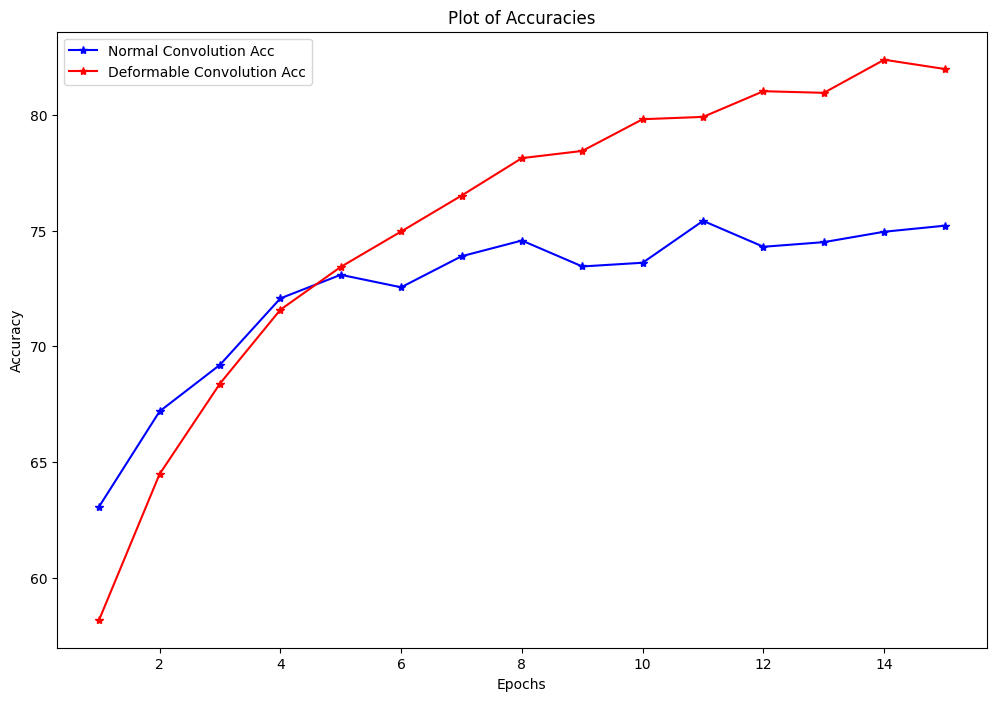

In [10]:

plt.figure(figsize=(12, 8))

# Plotting
plt.plot(range(1, 16), CNN_ACC , color='blue', marker = '*' , label='Normal Convolution Acc')
plt.plot(range(1, 16), DCNN_ACC, color ='red' , marker = '*' , label='Deformable Convolution Acc')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title ('Plot of Accuracies')
plt.legend()  # Display legend based on labels


plt.show()

The total execution time for each of the scenarios is printed in the last line of their respective code blocks. As evident and observed, it is true that the Deformable Convolution provides us with more flexibility, but achieving this flexibility comes at the cost of significantly increased computation time, often several times more. (However, it is essential to consider that we developed the code from scratch here, and using pre-built packages might offer a more optimized solution, potentially requiring less time.)